<a href="https://colab.research.google.com/github/tnwls6865/cau_deep_learning/blob/main/Word2Vec_and_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word2Vec

## Dense Representation

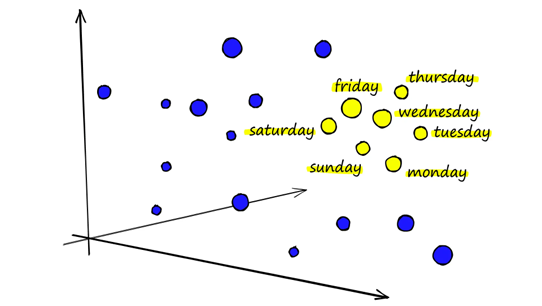

* 각 단어들을 효과적으로 연속형 벡터공간에 매핑할 수 있다면 장점이 많습니다.
    * 각 단어들간의 관계를 쉽게 볼 수 있습니다.
    * 차원의 수를 줄일 수 있습니다.
* 이렇게 연속형 벡터공간에 매핑하는 다양한 방법론이 있습니다.
    * 이번 실습에서는 word2vec을 활용해보도록 하겠습니다.

## Word2Vec 학습

In [1]:
import re
import urllib.request
import zipfile
from lxml import etree
from nltk.tokenize import word_tokenize, sent_tokenize

import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

### 데이터 불러오기 (영어)

데이터는 온라인에 있는 ted강연내용 일부를 가져와서 활용하겠습니다.

In [2]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/ted_en-20160408.xml", filename="ted_en-20160408.xml")

('ted_en-20160408.xml', <http.client.HTTPMessage at 0x7b4f295f1d20>)

In [3]:
targetXML = open('ted_en-20160408.xml', 'r', encoding='UTF8')
target_text = etree.parse(targetXML)

In [4]:
# xml 파일로부터 <content>와 </content> 사이의 내용만 가져온다.
parse_text = '\n'.join(target_text.xpath('//content/text()'))

In [5]:
parse_text[:500]

"Here are two reasons companies fail: they only do more of the same, or they only do what's new.\nTo me the real, real solution to quality growth is figuring out the balance between two activities: exploration and exploitation. Both are necessary, but it can be too much of a good thing.\nConsider Facit. I'm actually old enough to remember them. Facit was a fantastic company. They were born deep in the Swedish forest, and they made the best mechanical calculators in the world. Everybody used them. A"

### 데이터 전처리 (영어)

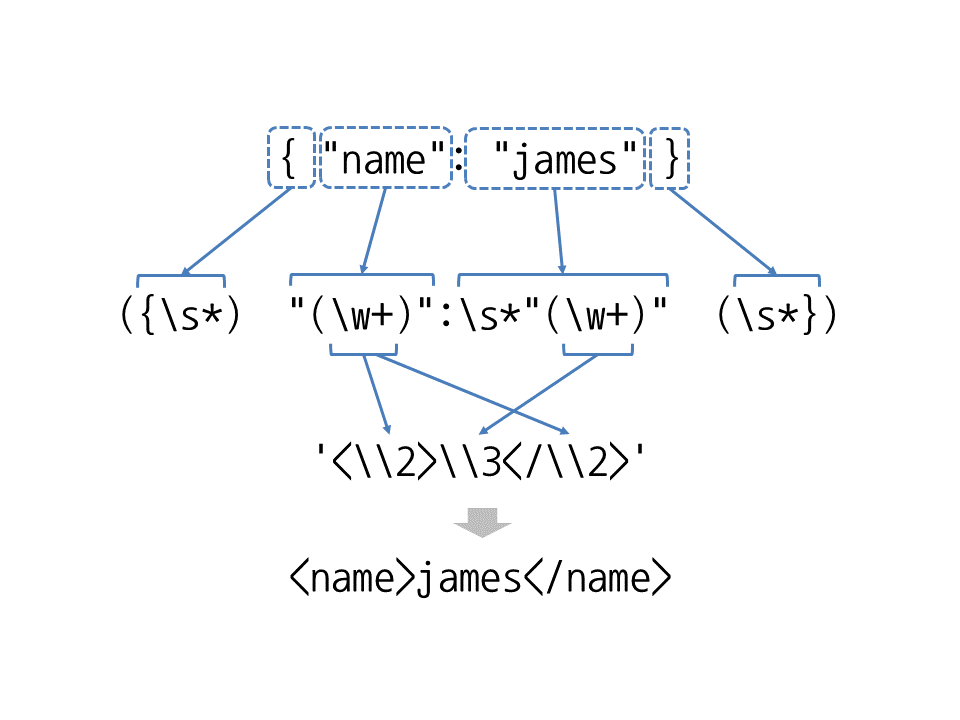

정규표현식은 특정한 규칙을 가진 문자열의 집합을 표현하는 데 사용하는 형식 언어이다. 정규 표현식은 많은 텍스트 편집기와 프로그래밍 언어에서 문자열의 검색과 치환을 위해 지원하고 있으며, 특히 펄과 Tcl은 언어 자체에 강력한 정규 표현식을 구현하고 있다.

컴퓨터 과학의 정규 언어로부터 유래하였으나 구현체에 따라서 정규 언어보다 더 넓은 언어를 표현할 수 있는 경우도 있으며, 심지어 정규 표현식 자체의 문법도 여러 가지 존재하고 있다. (from Wikipedia)

In [6]:
# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거.
# 해당 코드는 괄호로 구성된 내용을 제거.
content_text = re.sub(r'\([^)]*\)', '', parse_text)

In [7]:
# 입력 코퍼스에 대해서 NLTK를 이용하여 문장 토큰화를 수행.
sent_text = sent_tokenize(content_text)

In [8]:
# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환.
normalized_text = []
for string in sent_text:
     tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
     normalized_text.append(tokens)

### 토크나이징 (영어)

In [9]:
# 각 문장에 대해서 NLTK를 이용하여 단어 토큰화를 수행.
result = [word_tokenize(sentence) for sentence in normalized_text]

In [10]:
# 샘플 3개만 출력
for line in result[:3]:
    print(line)

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


### Word2Vec 모델 학습 (영어)

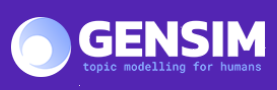

Gensim1은 자연어 처리를 위한 오픈 소스 파이썬 라이브러리로, 특히 주제 모델링과 문서 유사성 분석에 초점을 맞추고 있습니다. "Generate Similar"의 약어인 Gensim은 대용량 텍스트 데이터를 효율적으로 처리할 수 있도록 설계되었습니다. 이 라이브러리는 머신 러닝과 벡터 공간 모델링에 관심 있는 개발자와 연구자들에게 유용합니다.

주요 기능

* 효율적인 텍스트 처리: 대규모 코퍼스의 효율적인 처리를 지원합니다.
* 주제 모델링: Latent Dirichlet Allocation(LDA), Latent Semantic Analysis(LSA) 등의 알고리즘을 통해 텍스트 데이터에서 주제를 추출할 수 있습니다.
* 문서 유사성 분석: 코사인 유사도, 유클리드 거리 등 다양한 메트릭을 사용하여 문서 간 유사성을 계산합니다.
* 단어 임베딩: Word2Vec, FastText와 같은 모델을 사용하여 단어를 벡터 공간에 매핑할 수 있습니다.


In [11]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

model = Word2Vec(sentences=result, vector_size=100, window=5, min_count=5, workers=4, sg=True)

* vector_size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.
* window = 컨텍스트 윈도우 크기
* min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)
* workers = 학습을 위한 프로세스 수
* sg = True는 Skip-gram, False는 CBOW.

### Word2Vec 활용 (영어)

In [12]:
model_result = model.wv.most_similar("man")
print(model_result[:5])

[('woman', 0.7402639985084534), ('guy', 0.7391663789749146), ('soldier', 0.7390332818031311), ('boy', 0.7109364867210388), ('michelangelo', 0.6932040452957153)]


In [13]:
model_result = model.wv.most_similar("woman")
print(model_result[:5])

[('girl', 0.7886785268783569), ('man', 0.7402639985084534), ('soldier', 0.7162784337997437), ('lady', 0.7161000370979309), ('daughter', 0.6909706592559814)]


In [14]:
model_result = model.wv.most_similar("good")
print(model_result[:5])

[('bad', 0.8294807076454163), ('great', 0.6486929059028625), ('stressful', 0.6461029052734375), ('simplistic', 0.6452831029891968), ('chariot', 0.6344335675239563)]


In [15]:
similar_ = model.wv.similarity('man', 'woman')
print(similar_)

0.740264


In [16]:
similar_ = model.wv.similarity('nice', 'woman')
print(similar_)

0.27851027


In [17]:
similar_ = model.wv.similarity('good', 'bad')
print(similar_)

0.82948065


### 데이터 불러오기 (한글)

In [18]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2024-11-14 11:40:57--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/g8l6dlu5a3ebovcdymluq/mecab-0.996-ko-0.9.2.tar.gz?rlkey=xlooryouhr1l2ufqbt93ohfvy&dl=1 [following]
--2024-11-14 11:40:58--  https://www.dropbox.com/scl/fi/g8l6dlu5a3ebovcdymluq/mecab-0.996-ko-0.9.2.tar.gz?rlkey=xlooryouhr1l2ufqbt93ohfvy&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6c22867e8a1564071c9041fe1e.dl.dropboxusercontent.com/cd/0/inline/CeW2gmnlK5B1YeNn8vAatFnn4zKnnaRTojbRsq1koFISu1rWXkhUlA3NtQdiu-VyEiVwjnd5ocI45gfOPUvvfMBhGqgGPD1FAMMdP3XV4J16McvN-I3Ba-mbT3xDA_rSokABeAH2ZH-w0r35KRfKHUwr/file?dl=1# [following]
--2024-11-14 11:40:59--  https://u

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7b4f08172290>)

In [20]:
train_data = pd.read_table('ratings.txt')
train_data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [21]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data)

              id                                           document  label
0        8112052                                어릴때보고 지금다시봐도 재밌어요ㅋㅋ      1
1        8132799  디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...      1
2        4655635               폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.      1
3        9251303  와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...      1
4       10067386                        안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.      1
...          ...                                                ...    ...
199995   8963373                                     포켓 몬스터 짜가 ㅡㅡ;;      0
199996   3302770                                              쓰.레.기      0
199997   5458175                  완전 사이코영화. 마지막은 더욱더 이 영화의질을 떨어트린다.      0
199998   6908648                왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ      0
199999   8548411                                    포풍저그가나가신다영차영차영차      0

[199992 rows x 3 columns]


### 데이터 전처리 (한글)

In [22]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)

In [23]:
train_data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


### 토크나이징 (한글)

In [24]:
from tqdm.notebook import tqdm

# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()

tokenized_data = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)


  0%|          | 0/199992 [00:00<?, ?it/s]

### Word2Vec 모델 학습 (한글)

In [25]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, vector_size = 100, window = 5, min_count = 5, workers = 4, sg = False)

### Word2Vec 모델 활용 (한글)

In [26]:
print(model.wv.most_similar("최민식"))

[('이정재', 0.8357735872268677), ('김명민', 0.8315864205360413), ('류덕환', 0.8305135369300842), ('김창완', 0.8302568197250366), ('한석규', 0.8140692710876465), ('이민호', 0.8134609460830688), ('유다인', 0.8127594590187073), ('안성기', 0.8123870491981506), ('박중훈', 0.8085886240005493), ('최민수', 0.7946373820304871)]


In [27]:
print(model.wv.most_similar("히어로"))

[('무협', 0.8606879115104675), ('슬래셔', 0.8592278361320496), ('느와르', 0.847256064414978), ('호러', 0.8328003883361816), ('물', 0.82030189037323), ('물의', 0.8069257140159607), ('블록버스터', 0.8063918948173523), ('무비', 0.7989715337753296), ('정통', 0.7890808582305908), ('멜로', 0.7738869786262512)]


## 사전학습된 Word2Vec 불러오기

In [28]:
import gensim.downloader

print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [29]:
word2vec_vectors = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [30]:
word2vec_vectors.most_similar('twitter')

[('Twitter', 0.8908904194831848),
 ('Twitter.com', 0.7536780834197998),
 ('tweet', 0.7431626319885254),
 ('tweeting', 0.7161932587623596),
 ('tweeted', 0.7137226462364197),
 ('facebook', 0.6988551616668701),
 ('tweets', 0.6974530816078186),
 ('Tweeted', 0.6950210928916931),
 ('Tweet', 0.6875007152557373),
 ('Tweeting', 0.6845167279243469)]

In [31]:
word2vec_vectors.vector_size

300

In [32]:
print(word2vec_vectors.similarity('man', 'woman'))

0.76640123


In [33]:
print(word2vec_vectors.similarity('post', 'book'))

0.057204384


In [34]:
print(word2vec_vectors['book'])

[ 0.11279297 -0.02612305 -0.04492188  0.06982422  0.140625    0.03039551
 -0.04370117  0.24511719  0.08740234 -0.05053711  0.23144531 -0.07470703
  0.21875     0.03466797 -0.14550781  0.05761719  0.00671387 -0.00701904
  0.13183594 -0.25390625  0.14355469 -0.140625   -0.03564453 -0.21289062
 -0.24804688  0.04980469 -0.09082031  0.14453125  0.05712891 -0.10400391
 -0.19628906 -0.20507812 -0.27539062  0.03063965  0.20117188  0.17382812
  0.09130859 -0.10107422  0.22851562 -0.04077148  0.02709961 -0.00106049
  0.02709961  0.34179688 -0.13183594 -0.078125    0.02197266 -0.18847656
 -0.17480469 -0.05566406 -0.20898438  0.04858398 -0.07617188 -0.15625
 -0.05419922  0.01672363 -0.02722168 -0.11132812 -0.03588867 -0.18359375
  0.28710938  0.01757812  0.02185059 -0.05664062 -0.01251221  0.01708984
 -0.21777344 -0.06787109  0.04711914 -0.00668335  0.08544922 -0.02209473
  0.31835938  0.01794434 -0.02246094 -0.03051758 -0.09570312  0.24414062
  0.20507812  0.05419922  0.29101562  0.03637695  0.04

# Text Classification

## Recurrent Neural Network

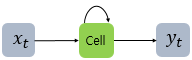

RNN은 은닉층의 노드에서 활성화 함수를 통해 나온 결과값을 출력층 방향으로도 보내면서, 다시 은닉층 노드의 다음 계산의 입력으로 보내는 특징을 갖고있습니다.

In [35]:
import torch.nn as nn

class RNN_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(RNN_Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim) # output_dim = 분류하고자하는 카테고리의 개수

    def forward(self, x):
        # x: (batch_size, seq_length) == (32, 500)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim) == (32, 500, 100) == (데이터의 개수, 문장길이, 단어 벡터의 차원)
        gru_out, hidden = self.gru(embedded)  # gru_out: (batch_size, seq_length, hidden_dim), hidden: (1, batch_size, hidden_dim)
        last_hidden = hidden.squeeze(0)  # (batch_size, hidden_dim)
        logits = self.fc(last_hidden)  # (batch_size, output_dim)
        return logits

## IMDb Text Classification (영어)

### 데이터 불러오기 (IMDb 데이터셋)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import torch
import urllib.request
from tqdm import tqdm
from collections import Counter
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

In [37]:
!pip install datasets

from datasets import load_dataset

ds = load_dataset("stanfordnlp/imdb")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [38]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [39]:
X_train = ds['train']['text']
X_test = ds['test']['text']
y_train = ds['train']['label']
y_test = ds['test']['label']

In [40]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.2, random_state=0, stratify=y_train)

### 전처리 및 토크나이징

In [41]:
def tokenize(sentences):
  tokenized_sentences = []
  for sent in tqdm(sentences):
    tokenized_sent = word_tokenize(sent)
    tokenized_sent = [word.lower() for word in tokenized_sent]
    tokenized_sentences.append(tokenized_sent)
  return tokenized_sentences

tokenized_X_train = tokenize(X_train)
tokenized_X_valid = tokenize(X_valid)
tokenized_X_test = tokenize(X_test)

100%|██████████| 25000/25000 [01:09<00:00, 361.40it/s]


In [42]:
for sent in tokenized_X_train[:2]:
  print(sent)

['excellent', 'movie', ',', 'a', 'realistic', 'picture', 'of', 'contemporary', 'finland', ',', 'touching', 'and', 'profound', '.', 'one', 'of', 'the', 'best', 'finnish', 'films', 'ever', 'made', '.', 'captures', 'marvelously', 'the', 'everyday', 'life', 'in', 'a', 'central', 'finland', 'small', 'town', ',', 'people', "'s", 'desires', 'and', 'weaknesses', ',', 'joys', 'and', 'sorrows', '.', 'the', 'bright', 'early', 'fall', 'sunshine', 'creates', 'a', 'cool', 'atmosphere', 'to', 'this', 'lucid', 'examination', 'of', 'people', 'in', 'a', 'welfare', 'society', '.', 'lampela', 'is', 'indeed', 'one', 'of', 'the', 'most', 'promising', 'finnish', 'filmmakers', '.', 'he', 'shows', 'that', 'it', 'is', 'possible', 'to', 'make', 'gripping', 'movies', 'without', 'machine', 'guns', 'and', 'bloodshed', '.', 'his', 'next', 'film', 'eila', 'is', 'also', 'worth', 'seeing', 'although', 'the', 'story', 'of', 'cleaning', 'women', 'fighting', 'for', 'their', 'jobs', 'is', 'not', 'quite', 'as', 'universally

### 재-전처리 (Vocab 만들기)

In [43]:
word_list = []
for sent in tokenized_X_train:
    for word in sent:
      word_list.append(word)

word_counts = Counter(word_list)
print('총 단어수 :', len(word_counts))

총 단어수 : 99343


In [44]:
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
print('등장 빈도수 상위 10개 단어')
print(vocab[:10])

등장 빈도수 상위 10개 단어
['the', ',', '.', 'and', 'a', 'of', 'to', 'is', '/', '>']


In [45]:
threshold = 3
total_cnt = len(word_counts) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 99343
등장 빈도가 2번 이하인 희귀 단어의 수: 60989
단어 집합에서 희귀 단어의 비율: 61.3923477245503
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.2911848331816018


In [46]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
vocab_size = total_cnt - rare_cnt
vocab = vocab[:vocab_size]
print('단어 집합의 크기 :', len(vocab))

단어 집합의 크기 : 38354


In [47]:
word_to_index = {}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1

for index, word in enumerate(vocab) :
  word_to_index[word] = index + 2

vocab_size = len(word_to_index)
print('패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 :', vocab_size)

패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 : 38356


In [48]:
def texts_to_sequences(tokenized_X_data, word_to_index):
  encoded_X_data = []
  for sent in tokenized_X_data:
    index_sequences = []
    for word in sent:
      try:
          index_sequences.append(word_to_index[word])
      except KeyError:
          index_sequences.append(word_to_index['<UNK>'])
    encoded_X_data.append(index_sequences)
  return encoded_X_data

encoded_X_train = texts_to_sequences(tokenized_X_train, word_to_index)
encoded_X_valid = texts_to_sequences(tokenized_X_valid, word_to_index)
encoded_X_test = texts_to_sequences(tokenized_X_test, word_to_index)

In [49]:
# 상위 샘플 2개 출력
for sent in encoded_X_train[:2]:
  print(sent)

[326, 24, 3, 6, 818, 432, 7, 2418, 17448, 3, 1236, 5, 3242, 4, 40, 7, 2, 135, 10695, 125, 140, 111, 4, 2215, 10388, 2, 2862, 137, 15, 6, 1358, 17448, 409, 522, 3, 98, 19, 5367, 5, 5890, 3, 10696, 5, 14926, 4, 2, 2007, 403, 787, 3646, 2018, 6, 662, 833, 8, 17, 14927, 5048, 7, 98, 15, 6, 15638, 898, 4, 1, 9, 868, 40, 7, 2, 108, 2275, 10695, 1031, 4, 36, 291, 18, 14, 9, 632, 8, 114, 3133, 118, 219, 1694, 1970, 5, 8909, 4, 37, 384, 26, 1, 9, 100, 301, 324, 268, 2, 79, 7, 6445, 352, 1017, 22, 80, 2554, 9, 34, 195, 21, 10697, 2216, 21, 2, 21191, 15, 1, 4]
[16, 1, 73, 8, 2, 1465, 994, 17, 8, 39, 6, 941, 3787, 30, 6, 22998, 2298, 276, 25, 20, 3647, 782, 4, 117, 2167, 160, 33, 2285, 329, 19729, 31, 16, 77, 71, 1751, 8, 81, 6, 8512, 15, 62, 1240, 2298, 22999, 539, 5, 16, 86, 32, 4, 307, 1, 20, 63, 21, 2, 3788, 7659, 3, 1004, 3966, 20, 93, 194, 21, 6, 32153, 11026, 3, 5, 6156, 9849, 20, 3, 21, 223, 3, 6, 2987, 4, 120, 136, 18, 254, 120, 935, 3, 2, 826, 20, 7660, 4019, 5, 17, 275, 48, 6, 240, 18, 

### 재-전처리 (Padding)

리뷰의 최대 길이 : 2114
리뷰의 평균 길이 : 281.8574


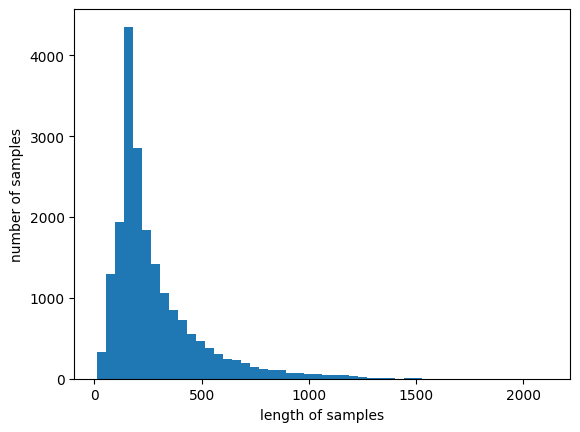

In [50]:
print('리뷰의 최대 길이 :',max(len(review) for review in encoded_X_train))
print('리뷰의 평균 길이 :',sum(map(len, encoded_X_train))/len(encoded_X_train))
plt.hist([len(review) for review in encoded_X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [51]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

max_len = 500
below_threshold_len(max_len, encoded_X_train)

전체 샘플 중 길이가 500 이하인 샘플의 비율: 87.47500000000001


In [52]:
def pad_sequences(sentences, max_len):
  features = np.zeros((len(sentences), max_len), dtype=int)
  for index, sentence in enumerate(sentences):
    if len(sentence) != 0:
      features[index, :len(sentence)] = np.array(sentence)[:max_len]
  return features

padded_X_train = pad_sequences(encoded_X_train, max_len=max_len)
padded_X_valid = pad_sequences(encoded_X_valid, max_len=max_len)
padded_X_test = pad_sequences(encoded_X_test, max_len=max_len)

print('훈련 데이터의 크기 :', padded_X_train.shape)
print('검증 데이터의 크기 :', padded_X_valid.shape)
print('테스트 데이터의 크기 :', padded_X_test.shape)

훈련 데이터의 크기 : (20000, 500)
검증 데이터의 크기 : (5000, 500)
테스트 데이터의 크기 : (25000, 500)


### 모델링

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [25]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함:", device)

cpu와 cuda 중 다음 기기로 학습함: cuda


In [55]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim) # output_dim = 분류하고자하는 카테고리의 개수

    def forward(self, x):
        # x: (batch_size, seq_length) == (32, 500)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim) == (32, 500, 100) == (데이터의 개수, 문장길이, 단어 벡터의 차원)
        gru_out, hidden = self.gru(embedded)  # gru_out: (batch_size, seq_length, hidden_dim), hidden: (1, batch_size, hidden_dim)
        last_hidden = hidden.squeeze(0)  # (batch_size, hidden_dim)
        logits = self.fc(last_hidden)  # (batch_size, output_dim)
        return logits

In [56]:
train_label_tensor = torch.tensor(np.array(y_train))
valid_label_tensor = torch.tensor(np.array(y_valid))
test_label_tensor = torch.tensor(np.array(y_test))

encoded_train = torch.tensor(padded_X_train).to(torch.int64)
train_dataset = torch.utils.data.TensorDataset(encoded_train, train_label_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)

encoded_test = torch.tensor(padded_X_test).to(torch.int64)
test_dataset = torch.utils.data.TensorDataset(encoded_test, test_label_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=1)

encoded_valid = torch.tensor(padded_X_valid).to(torch.int64)
valid_dataset = torch.utils.data.TensorDataset(encoded_valid, valid_label_tensor)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=True, batch_size=1)

In [57]:
embedding_dim = 100
hidden_dim = 128
output_dim = 2
learning_rate = 0.001
num_epochs = 10

model = TextClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 학습

In [28]:
def calculate_accuracy(logits, labels):
    # _, predicted = torch.max(logits, 1)
    predicted = torch.argmax(logits, dim=1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

def evaluate(model, valid_dataloader, criterion, device):
    val_loss = 0
    val_correct = 0
    val_total = 0

    model.eval()
    with torch.no_grad():
        # 데이터로더로부터 배치 크기만큼의 데이터를 연속으로 로드
        for batch_X, batch_y in valid_dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # 모델의 예측값
            logits = model(batch_X)

            # 손실을 계산
            loss = criterion(logits, batch_y)

            # 정확도와 손실을 계산함
            val_loss += loss.item()
            val_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
            val_total += batch_y.size(0)

    val_accuracy = val_correct / val_total
    val_loss /= len(valid_dataloader)

    return val_loss, val_accuracy

In [59]:
num_epochs = 7  # 총 학습을 몇 번 반복할 것인지 설정하는 변수, 여기서는 7번 반복합니다.

# Training loop
best_val_loss = float('inf')  # 검증 손실의 최저 값을 추적하기 위한 변수로, 초기값은 매우 큰 값으로 설정합니다.

# Training loop
for epoch in range(num_epochs):  # 설정된 에포크 수만큼 반복합니다.
    # Training
    train_loss = 0  # 에포크 동안의 전체 훈련 손실을 저장할 변수입니다.
    train_correct = 0  # 에포크 동안 올바르게 예측된 샘플의 수를 저장할 변수입니다.
    train_total = 0  # 에포크 동안 처리된 총 샘플 수를 저장할 변수입니다.
    model.train()  # 모델을 훈련 모드로 설정합니다.

    for batch_X, batch_y in train_dataloader:  # 훈련 데이터셋을 배치 단위로 반복합니다.
        # Forward pass
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # 배치 데이터를 GPU와 같은 장치에 올립니다.
        # batch_X.shape == (batch_size, max_len)
        logits = model(batch_X)  # 모델에 입력 데이터를 넣어 예측값(logits)을 계산합니다.

        # Compute loss
        loss = criterion(logits, batch_y)  # 예측값과 실제 값 간의 손실(loss)을 계산합니다.

        # Backward pass and optimization
        optimizer.zero_grad()  # 이전 배치에서 계산된 기울기(gradient)를 초기화합니다.
        loss.backward()  # 역전파를 통해 기울기를 계산합니다.
        optimizer.step()  # 계산된 기울기를 사용하여 모델의 파라미터를 업데이트합니다.

        # Calculate training accuracy and loss
        train_loss += loss.item()  # 현재 배치의 손실을 전체 훈련 손실에 추가합니다.
        train_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)  # 정확도를 계산하여 올바르게 예측된 샘플 수를 추가합니다.
        train_total += batch_y.size(0)  # 현재 배치의 샘플 수를 전체 샘플 수에 추가합니다.

    train_accuracy = train_correct / train_total  # 전체 훈련 데이터에 대한 정확도를 계산합니다.
    train_loss /= len(train_dataloader)  # 배치 수로 나누어 평균 훈련 손실을 계산합니다.

    # Validation
    val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)  # 검증 데이터로 모델을 평가하여 손실과 정확도를 계산합니다.

    print(f'Epoch {epoch+1}/{num_epochs}:')  # 현재 에포크 번호와 총 에포크 수를 출력합니다.
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')  # 훈련 손실과 정확도를 출력합니다.
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')  # 검증 손실과 정확도를 출력합니다.

    # 검증 손실이 최소일 때 체크포인트 저장
    if val_loss < best_val_loss:  # 현재 검증 손실이 이전의 최저 손실보다 낮으면
        print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. 체크포인트를 저장합니다.')  # 손실이 개선되었음을 출력합니다.
        best_val_loss = val_loss  # 최저 검증 손실을 현재 손실로 업데이트합니다.
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')  # 현재 모델의 가중치를 파일로 저장합니다.

Epoch 1/7:
Train Loss: 0.6969, Train Accuracy: 0.5013
Validation Loss: 0.6934, Validation Accuracy: 0.5044
Validation loss improved from inf to 0.6934. 체크포인트를 저장합니다.
Epoch 2/7:
Train Loss: 0.6911, Train Accuracy: 0.5128
Validation Loss: 0.6962, Validation Accuracy: 0.4996
Epoch 3/7:
Train Loss: 0.6727, Train Accuracy: 0.5703
Validation Loss: 0.6408, Validation Accuracy: 0.6502
Validation loss improved from 0.6934 to 0.6408. 체크포인트를 저장합니다.
Epoch 4/7:
Train Loss: 0.5282, Train Accuracy: 0.7414
Validation Loss: 0.4951, Validation Accuracy: 0.7760
Validation loss improved from 0.6408 to 0.4951. 체크포인트를 저장합니다.
Epoch 5/7:
Train Loss: 0.3520, Train Accuracy: 0.8534
Validation Loss: 0.3920, Validation Accuracy: 0.8338
Validation loss improved from 0.4951 to 0.3920. 체크포인트를 저장합니다.
Epoch 6/7:
Train Loss: 0.2323, Train Accuracy: 0.9133
Validation Loss: 0.3542, Validation Accuracy: 0.8550
Validation loss improved from 0.3920 to 0.3542. 체크포인트를 저장합니다.
Epoch 7/7:
Train Loss: 0.1399, Train Accuracy: 0.95

### 평가

In [60]:
# 모델 로드
model.load_state_dict(torch.load('best_model_checkpoint.pth'))

# 모델을 device에 올립니다.
model.to(device)

<ipython-input-60-4cd7d8c4ec6d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_checkpoint.pth'))


TextClassifier(
  (embedding): Embedding(38356, 100)
  (gru): GRU(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [61]:
# 검증 데이터에 대한 정확도와 손실 계산
val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')

Best model validation loss: 0.3542
Best model validation accuracy: 0.8550


In [62]:
index_to_tag = {0 : '부정', 1 : '긍정'}

def predict(text, model, word_to_index, index_to_tag):
    # 모델 평가 모드
    model.eval()

    # 토큰화 및 정수 인코딩. OOV 문제 발생 시 <UNK> 토큰에 해당하는 인덱스 1 할당
    tokens = word_tokenize(text)
    token_indices = [word_to_index.get(token.lower(), 1) for token in tokens]

    # 리스트를 텐서로 변경
    input_tensor = torch.tensor([token_indices], dtype=torch.long).to(device)  # (1, seq_length)

    # 모델의 예측
    with torch.no_grad():
        logits = model(input_tensor)  # (1, output_dim)

    # 레이블 인덱스 예측
    _, predicted_index = torch.max(logits, dim=1)  # (1,)

    # 인덱스와 매칭되는 카테고리 문자열로 변경
    predicted_tag = index_to_tag[predicted_index.item()]

    return predicted_tag

In [63]:
test_input = "This movie was just way too overrated. The fighting was not professional and in slow motion. I was expecting more from a 200 million budget movie. The little sister of T.Challa was just trying too hard to be funny. The story was really dumb as well. Don't watch this movie if you are going because others say its great unless you are a Black Panther fan or Marvels fan."

predict(test_input, model, word_to_index, index_to_tag)

'부정'

## NSMC Text Classification (한글)

### 데이터 불러오기 (NSMC 데이터셋)

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7b6b12da5990>)

In [3]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [4]:
# document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [5]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
train_data = train_data.dropna(how = 'any')
train_data.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


### 데이터 전처리

In [6]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True) # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "", regex=True) # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


<ipython-input-6-59211301370a>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경


### 토크나이징

In [7]:
from konlpy.tag import Okt

stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔')

['와', '이런', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만드는', '게', '나을', '뻔']

In [8]:
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

print(X_train[:3])

100%|██████████| 146182/146182 [09:51<00:00, 247.01it/s]

[['아', '더빙', '진짜', '짜증나네요', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍지', '않구나'], ['너', '무재', '밓었', '다그', '래서', '보는것을', '추천']]


In [9]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [03:38<00:00, 223.96it/s]


In [10]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0, stratify=y_train)

### Vocab 만들기

In [12]:
word_list = []
for sent in X_train:
    for word in sent:
      word_list.append(word)

word_counts = Counter(word_list)
print('총 단어수 :', len(word_counts))

vocab = sorted(word_counts, key=word_counts.get, reverse=True)

threshold = 5
total_cnt = len(word_counts) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

vocab_size = total_cnt - rare_cnt
vocab = vocab[:vocab_size]
print('단어 집합의 크기 :', len(vocab))

총 단어수 : 88340
단어 집합의 크기 : 18893


In [13]:
word_to_index = {}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1

for index, word in enumerate(vocab) :
  word_to_index[word] = index + 2

vocab_size = len(word_to_index)
print('패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 :', vocab_size)

def texts_to_sequences(tokenized_X_data, word_to_index):
  encoded_X_data = []
  for sent in tokenized_X_data:
    index_sequences = []
    for word in sent:
      try:
          index_sequences.append(word_to_index[word])
      except KeyError:
          index_sequences.append(word_to_index['<UNK>'])
    encoded_X_data.append(index_sequences)
  return encoded_X_data

패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 : 18895


In [30]:
encoded_X_train = texts_to_sequences(X_train, word_to_index)
encoded_X_valid = texts_to_sequences(X_valid, word_to_index)
encoded_X_test = texts_to_sequences(X_test, word_to_index)

def pad_sequences(sentences, max_len):
  features = np.zeros((len(sentences), max_len), dtype=int)
  for index, sentence in enumerate(sentences):
    if len(sentence) != 0:
      features[index, :len(sentence)] = np.array(sentence)[:max_len]
  return features

padded_X_train = pad_sequences(encoded_X_train, max_len=30)
padded_X_valid = pad_sequences(encoded_X_valid, max_len=30)
padded_X_test = pad_sequences(encoded_X_test, max_len=30)

print('훈련 데이터의 크기 :', padded_X_train.shape)
print('검증 데이터의 크기 :', padded_X_valid.shape)
print('테스트 데이터의 크기 :', padded_X_test.shape)

훈련 데이터의 크기 : (116945, 30)
검증 데이터의 크기 : (29237, 30)
테스트 데이터의 크기 : (48852, 30)


### 모델링

In [33]:
import torch.nn as nn

class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)

        # LSTM은 (hidden state, cell state)의 튜플을 반환합니다
        lstm_out, (hidden, cell) = self.lstm(embedded)  # lstm_out: (batch_size, seq_length, hidden_dim), hidden: (1, batch_size, hidden_dim)

        last_hidden = hidden.squeeze(0)  # (batch_size, hidden_dim)
        logits = self.fc(last_hidden)  # (batch_size, output_dim)
        return logits

In [34]:
train_label_tensor = torch.tensor(np.array(y_train))
valid_label_tensor = torch.tensor(np.array(y_valid))
test_label_tensor = torch.tensor(np.array(y_test))

encoded_train = torch.tensor(padded_X_train).to(torch.int64)
train_dataset = torch.utils.data.TensorDataset(encoded_train, train_label_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=64)

encoded_test = torch.tensor(padded_X_test).to(torch.int64)
test_dataset = torch.utils.data.TensorDataset(encoded_test, test_label_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=1)

encoded_valid = torch.tensor(padded_X_valid).to(torch.int64)
valid_dataset = torch.utils.data.TensorDataset(encoded_valid, valid_label_tensor)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=True, batch_size=1)

In [35]:
embedding_dim = 100
hidden_dim = 128
output_dim = 2
learning_rate = 0.001
num_epochs = 10

model = TextClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 학습 및 평가

In [36]:
# Training loop
best_val_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    # Training
    train_loss = 0
    train_correct = 0
    train_total = 0
    model.train()
    for batch_X, batch_y in train_dataloader:
        # Forward pass
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        # batch_X.shape == (batch_size, max_len)
        logits = model(batch_X)

        # Compute loss
        loss = criterion(logits, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy and loss
        train_loss += loss.item()
        train_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
        train_total += batch_y.size(0)

    train_accuracy = train_correct / train_total
    train_loss /= len(train_dataloader)

    # Validation
    val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # 검증 손실이 최소일 때 체크포인트 저장
    if val_loss < best_val_loss:
        print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. 체크포인트를 저장합니다.')
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_checkpoint2.pth')

Epoch 1/10:
Train Loss: 0.5338, Train Accuracy: 0.6959
Validation Loss: 0.4050, Validation Accuracy: 0.8148
Validation loss improved from inf to 0.4050. 체크포인트를 저장합니다.
Epoch 2/10:
Train Loss: 0.3480, Train Accuracy: 0.8456
Validation Loss: 0.3673, Validation Accuracy: 0.8359
Validation loss improved from 0.4050 to 0.3673. 체크포인트를 저장합니다.
Epoch 3/10:
Train Loss: 0.2824, Train Accuracy: 0.8800
Validation Loss: 0.3671, Validation Accuracy: 0.8370
Validation loss improved from 0.3673 to 0.3671. 체크포인트를 저장합니다.
Epoch 4/10:
Train Loss: 0.2270, Train Accuracy: 0.9063
Validation Loss: 0.3958, Validation Accuracy: 0.8391
Epoch 5/10:
Train Loss: 0.1755, Train Accuracy: 0.9298
Validation Loss: 0.4370, Validation Accuracy: 0.8343
Epoch 6/10:
Train Loss: 0.1313, Train Accuracy: 0.9488
Validation Loss: 0.5258, Validation Accuracy: 0.8306
Epoch 7/10:
Train Loss: 0.1005, Train Accuracy: 0.9618
Validation Loss: 0.5874, Validation Accuracy: 0.8307
Epoch 8/10:
Train Loss: 0.0790, Train Accuracy: 0.9702
Valida

In [37]:
# 모델 로드
model.load_state_dict(torch.load('best_model_checkpoint2.pth'))

# 모델을 device에 올립니다.
model.to(device)

# 검증 데이터에 대한 정확도와 손실 계산
val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')

<ipython-input-37-7541f82edb2a>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_checkpoint2.pth'))


Best model validation loss: 0.3671
Best model validation accuracy: 0.8370


In [40]:
index_to_tag = {0 : '부정', 1 : '긍정'}

def predict(text, model, word_to_index, index_to_tag):
    # Set the model to evaluation mode
    model.eval()

    # Tokenize the input text
    tokens = okt.morphs(text) # 토큰화
    tokens = [word for word in tokens if not word in stopwords] # 불용어 제거
    token_indices = [word_to_index.get(token, 1) for token in tokens]

    # Convert tokens to tensor
    input_tensor = torch.tensor([token_indices], dtype=torch.long).to(device)  # (1, seq_length)

    # Pass the input tensor through the model
    with torch.no_grad():
        logits = model(input_tensor)  # (1, output_dim)

    # Get the predicted class index
    predicted_index = torch.argmax(logits, dim=1)

    # Convert the predicted index to its corresponding tag
    predicted_tag = index_to_tag[predicted_index.item()]

    return predicted_tag

In [41]:
test_input = "이 영화 개꿀잼 ㅋㅋㅋ"
predict(test_input, model, word_to_index, index_to_tag)

'긍정'

In [42]:
test_input = "이딴게 영화냐 ㅉㅉ"
predict(test_input, model, word_to_index, index_to_tag)

'부정'